In [1]:
import sys
sys.path = ['lvis-api'] + sys.path

from lvis import LVISEval, LVISResults
from lvis import LVIS
import pycocotools.mask as mask_utils
import torch
from tqdm import tqdm

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch, cv2
import skimage.io as io
%matplotlib inline

In [411]:
%ls /scratch/users/zzweng/runs/checkpoints/freeze_coco_pretrain_hyp=True_zdim=64_loss=triplet/
# %ls inference

model_0.pth      model_40000.pth  rpn_model_10000.pth  rpn_model_50000.pth
model_10000.pth  model_50000.pth  rpn_model_20000.pth  rpn_model_60000.pth
model_20000.pth  model_60000.pth  rpn_model_30000.pth
model_30000.pth  rpn_model_0.pth  rpn_model_40000.pth


Train split: (57263, 693958)
Val split: (5000, 50763)

In [14]:
from models.rpn import ProposalNetwork
import skimage
import torchvision.transforms as T
from models.rpn import get_modelzoo_config
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [230]:
from simclr_lvis import keep

In [15]:
rpn = ProposalNetwork(device='cuda')
cfg = rpn.cfg

Build Predictor using cfg


In [18]:
%ls /scratch/users/zzweng/datasets/coco/annotations

captions_train2014.json  captions_val2017.json     instances_val2014.json
captions_train2017.json  instances_train2014.json  instances_val2017.json
captions_val2014.json    instances_train2017.json  lvis_v0.5_train.json


In [232]:
cfg = get_cfg()

CFG_FILE =  r'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
cfg.merge_from_file(model_zoo.get_config_file(CFG_FILE))
cfg.INPUT.FORMAT = 'RGB'
cfg.MODEL.ROI_MASK_HEAD.CLS_AGNOSTIC_MASK = True
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 100
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 50
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CFG_FILE)
cfg.MODEL.WEIGHTS = r'/scratch/users/zzweng/output/coco/classagnostic1/model_0021999.pth'
# cfg.MODEL.WEIGHTS = r'/scratch/users/zzweng/runs/checkpoints/freeze_coco_pretrain_hyp=False_zdim=256_loss=nce/rpn_model_10000.pth'
rpn.predictor = DefaultPredictor(cfg)

In [234]:
out = rpn(torch.tensor(I))[0]['instances']

In [235]:
print(len(out))
idx = [i for i in range(len(out.pred_masks)) if keep(i, out.pred_masks)]
out = out[idx]
print(len(out))

50
11


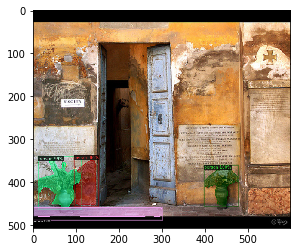

In [236]:
v = Visualizer(I, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(out[:4].to("cpu"))
plt.figure()
plt.imshow(v.get_image())

In [4]:
# v = Visualizer(I, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# v = v.draw_instance_predictions(out[4:].to("cpu"))
# plt.figure()
# plt.imshow(v.get_image())

In [4]:
%ls /scratch/users/zzweng/runs/checkpoints/freeze_coco_pretrain_hyp=True_zdim=2_loss=triplet

model_0.pth      model_20000.pth  rpn_model_0.pth      rpn_model_20000.pth
model_10000.pth  model_30000.pth  rpn_model_10000.pth  rpn_model_30000.pth


In [172]:
import json
coco_map = json.load(open('lvis-api/data/coco_to_synset.json'))

In [180]:
synset_to_lvis = {cat['synset']: cat['id'] for cat in evaluator.lvis.cats.values()}

In [186]:
synset_to_lvis['oven.n.01'] = synset_to_lvis['toaster_oven.n.01']
synset_to_lvis['frank.n.02'] = synset_to_lvis['sausage.n.01']

In [189]:
coco_to_lvis = {}
lvis_to_coco = {}
for item in coco_map.values():
    coco_id, lvis_id = item['coco_cat_id'], synset_to_lvis[item['synset']]
    coco_to_lvis[coco_id] = lvis_id
    lvis_to_coco[lvis_id] = coco_id

# Use Evaluator to evaluate

In [2]:
from eval_kmeans_lvis import Eval_KMeans
import numpy as np
from collections import Counter
%load_ext autoreload
%autoreload 2

In [3]:
evaluator = Eval_KMeans()

In [24]:
evaluator.load_gt_features(coco_only=False, k=0, freq_groups=[0])

(8659, 2048)
Filter by freq groups [0]
After: (87, 2048)


In [25]:
len(Counter(evaluator.feats_gt_y))

26

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

feats = evaluator.feats_gt
y = evaluator.feats_gt_y
train_feats, test_feats, train_y, test_y = train_test_split(feats, y)
neigh = KNeighborsClassifier(n_neighbors=1)#, weights='distance')
neigh.fit(train_feats, train_y)
print('KNN accuracy', neigh.score(train_feats, train_y))
print('KNN accuracy', neigh.score(test_feats, test_y))

KNN accuracy 1.0
KNN accuracy 0.7272727272727273


In [27]:
evaluator.fit_knn(3)

KNN accuracy 1.0


Run KMeans on the detected features

In [18]:
evaluator.load_dt_features()
evaluator.run_kmeans(C=2000)
evaluator.feats.shape

File features_lvis_dt/1300_1400.npy not found. Skipped.
File features_lvis_dt/1400_1500.npy not found. Skipped.
File features_lvis_dt/4300_4400.npy not found. Skipped.
File features_lvis_dt/4400_4500.npy not found. Skipped.
(30351, 2048)
Running KMeans ...


/scratch/users/zzweng/miniconda3/envs/simclr/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=2000. Setting it to 3*k
  init_size=init_size)
/scratch/users/zzweng/miniconda3/envs/simclr/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=2000. Setting it to 3*k
  init_size=init_size)
/scratch/users/zzweng/miniconda3/envs/simclr/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=2000. Setting it to 3*k
  init_size=init_size)


(30351, 2048)

In [19]:
Counter(evaluator.clusters)

Counter({1388: 89,
         1588: 5,
         432: 72,
         858: 1,
         363: 150,
         847: 216,
         1963: 134,
         1144: 94,
         95: 53,
         1939: 156,
         1170: 51,
         1821: 62,
         194: 238,
         1334: 64,
         249: 28,
         1503: 278,
         169: 83,
         970: 61,
         1132: 53,
         435: 53,
         694: 157,
         218: 200,
         406: 391,
         6: 179,
         279: 45,
         177: 403,
         1228: 87,
         1156: 53,
         106: 146,
         371: 112,
         1817: 149,
         7: 262,
         1867: 110,
         997: 40,
         1020: 55,
         790: 6,
         393: 67,
         481: 266,
         94: 136,
         1924: 15,
         1479: 115,
         274: 191,
         444: 52,
         1637: 5,
         1118: 103,
         499: 1,
         1831: 151,
         1756: 77,
         441: 14,
         368: 64,
         1471: 13,
         390: 2,
         1007: 30,
         53: 

In [46]:
# evaluator.load_dt_features()
# evaluator.run_hyperbolic_kmeans(C=80)

In [28]:
evaluator.assign_labels()

  0%|          | 5/1986 [00:00<00:51, 38.77it/s]

(30351, 2048)
Assigning labels using KNN ...


100%|██████████| 1986/1986 [00:11<00:00, 173.20it/s]


Number of assigned clusters: 1429


In [71]:
# np.save('clusters.npy', evaluator.clusters)
# np.save('cluster_to_coco.npy', evaluator.cluster_to_coco)

In [29]:
sorted(evaluator.cluster_to_coco.items(), key=lambda tup: -tup[1][2])

[(1899, (1205, 0.9805194805194806, 308)),
 (699, (843, 0.9623287671232876, 292)),
 (481, (843, 0.9887218045112782, 266)),
 (1446, (843, 0.9841269841269841, 189)),
 (129, (843, 0.9572192513368984, 187)),
 (3, (843, 1.0, 186)),
 (1843, (843, 0.9585798816568047, 169)),
 (86, (843, 0.9702380952380952, 168)),
 (694, (843, 0.9936305732484076, 157)),
 (962, (843, 0.9668874172185431, 151)),
 (1338, (843, 0.9536423841059603, 151)),
 (163, (843, 0.9523809523809523, 147)),
 (22, (843, 0.951048951048951, 143)),
 (351, (843, 0.9852941176470589, 136)),
 (1564, (843, 0.984375, 128)),
 (1890, (768, 1.0, 118)),
 (1505, (843, 0.9905660377358491, 106)),
 (160, (843, 0.9801980198019802, 101)),
 (1388, (843, 0.9887640449438202, 89)),
 (1509, (843, 0.9540229885057471, 87)),
 (1799, (843, 0.9625, 80)),
 (582, (843, 0.9661016949152542, 59)),
 (1716, (843, 0.9821428571428571, 56)),
 (917, (843, 1.0, 55)),
 (1426, (843, 1.0, 55)),
 (1132, (843, 0.9811320754716981, 53)),
 (444, (843, 0.9807692307692307, 52)),
 (

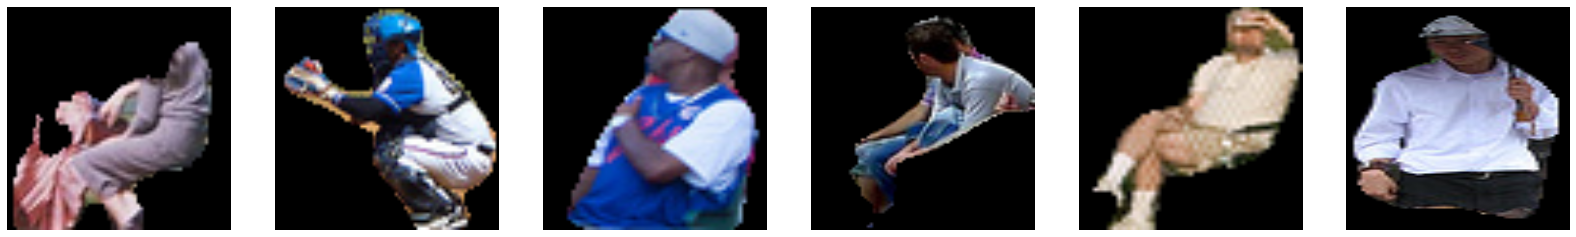

In [32]:
ann_ids = np.array(evaluator.feats_ann)[evaluator.clusters==1799]
# len(ann_ids)
fig, ax = plt.subplots(1,6, figsize=(28,28))
for i in range(6):
    ax[i].imshow(get_patch(evaluator.lvis_dt, ann_ids[i]))
    ax[i].axis('off')

In [33]:
evaluator.reload_annotations()
cocoDt = evaluator.lvis_dt
clusters = evaluator.clusters
feats_ann = evaluator.feats_ann

# cluster_to_coco = {v[0]: k for k, v in evaluator.coco_clusters.items()}
cluster_to_coco = evaluator.cluster_to_coco

# by default everything is -1.
for _, dt in cocoDt.anns.items(): dt['category_id'] = -1
print('Updating category ids')
for i in tqdm(range(len(feats_ann))):
    ann_id = int(feats_ann[i])
    cluster_id = clusters[i]
    if cluster_id in cluster_to_coco:
        cocoDt.anns[ann_id]['category_id'] = cluster_to_coco[cluster_id][0]

100%|██████████| 30351/30351 [00:00<00:00, 530349.25it/s]

Updating category ids


In [407]:
Counter([v['category_id'] for v in evaluator.lvis.anns.values()])

Counter({237: 593,
         428: 114,
         99: 633,
         1229: 297,
         277: 53,
         1196: 9,
         824: 112,
         260: 29,
         382: 110,
         429: 295,
         126: 1267,
         133: 260,
         637: 217,
         36: 443,
         1177: 143,
         1001: 123,
         289: 62,
         390: 188,
         26: 28,
         183: 421,
         851: 69,
         550: 500,
         146: 122,
         606: 393,
         538: 84,
         812: 31,
         801: 31,
         651: 113,
         299: 141,
         770: 51,
         926: 71,
         1092: 61,
         1144: 78,
         44: 8,
         977: 354,
         1211: 61,
         541: 5,
         560: 358,
         1201: 549,
         840: 699,
         174: 167,
         937: 34,
         480: 109,
         966: 477,
         35: 201,
         235: 131,
         118: 394,
         805: 487,
         24: 133,
         91: 160,
         59: 248,
         1099: 133,
         642: 105,
         85

In [408]:
Counter([v['category_id'] for v in evaluator.lvis_dt.anns.values()])

Counter({-1: 28281,
         805: 3039,
         211: 312,
         174: 177,
         229: 72,
         1229: 222,
         1001: 206,
         642: 72,
         1117: 49,
         429: 115,
         1099: 80,
         1135: 106,
         502: 142,
         1155: 80,
         276: 38,
         81: 10,
         452: 12,
         60: 3,
         13: 3})

In [35]:
cocoEval = LVISEval(evaluator.lvis, evaluator.lvis_dt,'segm')
# img_ids = cocoDt.get_img_ids()[700:1000]
# cocoEval.params.img_ids = img_ids

cocoEval.lvis_gt.cats[-1] = {'frequency': 'f',
  'id': -1, 'synset': 'all', 'image_count': 0, 'instance_count': 0,
  'synonyms': ['all'], 'def': '', 'name': 'all'}

# evaluator.lvis.cats[cat_id]['frequency']
#     print(Counter([evaluator.lvis.cats[v['category_id']]['frequency'] for v in cocoDt.anns.values()]))

cocoEval.params.cat_ids = set([v['category_id'] for v in evaluator.lvis_dt.anns.values()])-set([-1])
# cocoEval.params.cat_ids = evaluator.lvis_to_coco.keys()
cocoEval.params.iou_thrs = [0.25]


print(cocoEval.params.cat_ids, len(cocoEval.params.cat_ids))
print(cocoEval.params.iou_thrs)
# cocoEval.params.use_cats = 0

cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()
cocoEval.results

{768, 954, 1030, 326, 970, 843, 205, 1166, 725, 1112, 284, 413, 541, 676, 486, 423, 1000, 489, 745, 683, 941, 430, 241, 1205, 442, 703} 26
[0.25]


OrderedDict([('AP', 0.007996953541507994),
             ('AP50', -1),
             ('AP75', -1),
             ('APs', 0.0),
             ('APm', 0.0),
             ('APl', 0.14285714285714282),
             ('APr', 0.007996953541507994),
             ('APc', -1),
             ('APf', -1),
             ('AR@300', 0.007692307692307693),
             ('ARs@300', 0.0),
             ('ARm@300', 0.0),
             ('ARl@300', 0.14285714285714285)])

## Per Category Evaluation

In [242]:
for cat_id in set([v['category_id'] for v in self.lvis_dt.anns.values()])-set([-1]):
    cocoEval = LVISEval(self.lvis, self.lvis_dt,'segm')
    img_ids = cocoDt.get_img_ids()[700:1000]
    # cocoEval.params.img_ids = img_ids

    cocoEval.lvis_gt.cats[-1] = {'frequency': 'f',
      'id': -1, 'synset': 'all', 'image_count': 0, 'instance_count': 0,
      'synonyms': ['all'], 'def': '', 'name': 'all'}
    cocoEval.params.cat_ids = [cat_id]
#     print(cocoEval.params.cat_ids, len(cocoEval.params.cat_ids))

    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
    print(cat_id, cocoEval.results['AP'])

1155 0.03795713499921421
1091 0.047643206319961245
579 0.1275427215448182
714 0.0852242481790843
779 0.0495049504950495
1099 0.05126334061977626
1229 0.23880666778269136
211 0.09949664433860601
276 0.09711226584843358
347 0.0
221 0.0
1117 0.13217472708342307
805 0.09980688747860889
229 0.10705660658231722
1135 0.03611386138613862
502 0.23896469927116074
126 0.0
829 0.04500122491240721


In [567]:
len(cocoEval.freq_groups[0]), len(cocoEval.freq_groups[1]), len(cocoEval.freq_groups[2])

(0, 0, 1)

In [568]:
cocoEval.accumulate()
cocoEval.summarize()
cocoEval.results

OrderedDict([('AP', 0.08647126750322205),
             ('AP50', 0.18355573902344996),
             ('AP75', 0.07430600498964977),
             ('APs', 0.0),
             ('APm', 0.024257425742574258),
             ('APl', 0.10749389780968266),
             ('APr', -1),
             ('APc', -1),
             ('APf', 0.08647126750322205),
             ('AR@300', 0.162),
             ('ARs@300', 0.0),
             ('ARm@300', 0.03333333333333333),
             ('ARl@300', 0.20533333333333337)])

# Class Agnostic Evaluation

In [254]:
lvis_dt = evaluator.lvis_dt
lvis_gt = evaluator.lvis

for _, dt in lvis_dt.anns.items(): dt['category_id'] = -1
for _, dt in lvis_gt.anns.items(): dt['category_id'] = -1

lvisEval = LVISEval(lvis_gt, lvis_dt,'segm')
img_ids = lvis_dt.get_img_ids()[:100]
print(len(img_ids))

lvisEval.lvis_gt.cats[-1] = {'frequency': 'f',
  'id': -1,
  'synset': 'all',
  'image_count': 0,
  'instance_count': 0,
  'synonyms': ['all'],
  'def': 'nut from an oak tree',
  'name': 'all'}

# lvisEval.params.img_ids = img_ids
lvisEval.params.cat_ids = [-1]
lvisEval.params.use_cats = 0

lvisEval.evaluate()


100


In [255]:
lvisEval.accumulate()
lvisEval.summarize()

In [256]:
lvisEval.results

OrderedDict([('AP', 0.02002907059240924),
             ('AP50', 0.038989208511262204),
             ('AP75', 0.019153713196978818),
             ('APs', 0.015301515437811837),
             ('APm', 0.03231239911867449),
             ('APl', 0.04340486835279297),
             ('APr', -1),
             ('APc', -1),
             ('APf', 0.02002907059240924),
             ('AR@300', 0.07540286040739136),
             ('ARs@300', 0.030177206958218173),
             ('ARm@300', 0.11904003474987332),
             ('ARl@300', 0.20326122053600257)])

In [ ]:
OrderedDict([('AP', 0.02002907059240924),
             ('AP50', 0.038989208511262204),
             ('AP75', 0.019153713196978818),
             ('APs', 0.015301515437811837),
             ('APm', 0.03231239911867449),
             ('APl', 0.04340486835279297),
             ('APr', -1),
             ('APc', -1),
             ('APf', 0.02002907059240924),
             ('AR@300', 0.07540286040739136),
             ('ARs@300', 0.030177206958218173),
             ('ARm@300', 0.11904003474987332),
             ('ARl@300', 0.20326122053600257)])

In [12]:
def get_patch(api, ann_id):
    img_id = api.load_anns(ids=[ann_id])[0]['image_id']
    img = api.load_imgs([img_id])[0]
    I = io.imread(img['coco_url'])

    ann = api.load_anns(ids=[ann_id])[0]
    m = api.ann_to_mask(ann)
    b = np.array(ann['bbox']).astype(np.int)
    #         if b[2]*b[3] < 1024: continue
    patch = (I*m.reshape(*m.shape, 1))[b[1]:b[1]+b[3], b[0]:b[0]+b[2], :]
    #patch = I[b[1]:b[1]+b[3], b[0]:b[0]+b[2], :]
    patch = patch/255.
    patch = cv2.resize(patch, (224,224))
    return patch

In [ ]:
# from hyperbolic_kmeans import HyperbolicKMeans, poincare_dist
# from poincare_kmeans import PoincareKMeans
# hkmeans = HyperbolicKMeans(n_clusters=3)
# clusters = hkmeans.fit_predict(test_x_arr)